## Active learning

<img src="./Perception_4_ActiveLearning_7_OnlineLearning.png" alt="Drawing" style="width: 800px;"/>

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from utils import visualize, pickle_load, pickle_save
import torch
import numpy as np
from tqdm import tqdm
import segmentation_models_pytorch as smp
# segmentation models wrapper
from segmodel import SegModel, model_selection_function
# anomaly detection functions
from anomaly_detection import sample_selection_function
# datasets wrapper
from dataset import CamVid, BDD100K

### Load data

In [2]:
# # CamVid directories
# DATA_DIR = './data/CamVid/'

# x_train_dir = os.path.join(DATA_DIR, 'train')
# y_train_dir = os.path.join(DATA_DIR, 'trainannot')

# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'valannot')

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

# BDD100K directories
DATA_DIR = '/home/ruslan/datasets/bdd100k/seg/'
x_train_dir = os.path.join(DATA_DIR, 'images/train')
y_train_dir = os.path.join(DATA_DIR, 'labels/train')

x_valid_dir = os.path.join(DATA_DIR, 'images/val')
y_valid_dir = os.path.join(DATA_DIR, 'labels/val')

x_test_dir = os.path.join(DATA_DIR, 'images/test')

In [3]:
# all data paths
X_train_paths = np.array([os.path.join(x_train_dir, image_name) for image_name in os.listdir(x_train_dir)])
y_train_paths = np.array([os.path.join(y_train_dir, image_name) for image_name in os.listdir(y_train_dir)])

X_valid_paths = np.array([os.path.join(x_valid_dir, image_name) for image_name in os.listdir(x_valid_dir)])
y_valid_paths = np.array([os.path.join(y_valid_dir, image_name) for image_name in os.listdir(y_valid_dir)])

X_test_paths = np.array([os.path.join(x_test_dir, image_name) for image_name in os.listdir(x_test_dir)])
#y_test_paths = np.array([os.path.join(y_test_dir, image_name) for image_name in os.listdir(y_test_dir)])

### Active Learning experiment

- X_train, y_train: is used partially to train a model
- X_valid, y_valid: is used fully for validation
- X_test, y_test: is used as an unlabelled set to detect anomalies and add labels to train set

#### Main AL experiment

In [4]:
def al_experiment(model_str,
                  samples_selection_fn,
                  k,
                  visualize_most_uncertain=False,
                  verbose_train=False,
                  random_seed=0):
    # define model from its name
    model = model_selection_function(model_str)
    model.epochs = MODEL_TRAIN_EPOCHS
    # define samples selection function from its name
    samples_selection_fn = sample_selection_function(samples_selection_str)
    
    # select k random samples from initial dataset and treat it as initially labelled data
    X = np.copy(X_train_paths)
    y = np.copy(y_train_paths)
    np.random.seed(random_seed)
    initial_selection = np.random.choice(len(X), INITIAL_N_TRAIN_IMAGES, replace=False) # k
    X_train_paths_part = X[initial_selection]
    y_train_paths_part = y[initial_selection]

    X_test = np.delete(X, initial_selection)
    y_test = np.delete(X, initial_selection)

    IoUs = [0.]
    N_train_samples = [len(X_train_paths_part)]

    # main loop
    while len(X_train_paths_part) <= MAX_QUEERY_IMAGES:
        # train model
        print('Labelled set size: ', len(X_train_paths_part))
        print('Unlabelled set size: ', len(X_test))
        print(f'\nTraining a model for {MODEL_TRAIN_EPOCHS} epochs...')
        model.train(X_train_paths_part,
                    y_train_paths_part,
                    X_valid_paths,
                    y_valid_paths,
                    Dataset=BDD100K,
                    verbose=verbose_train)

        # remeber results
        print(f'IoU so far: {model.max_iou_score}')
        IoUs.append(model.max_iou_score)
        N_train_samples.append(len(X_train_paths_part))
        
        if len(X_test) < k:
            print('\nNo more images in Unlabelled set')
            break
            
        selected_images_indexes = samples_selection_fn(X_test, k, model)

        # Add labels for uncertain images to train data
        #print('Labelled set before: ', len(X_train_paths_part))
        X_train_paths_part = np.concatenate([X_train_paths_part, X_test[selected_images_indexes]])
        y_train_paths_part = np.concatenate([y_train_paths_part, y_test[selected_images_indexes]])
        #print('Labelled set after: ', len(X_train_paths_part))

        # Visualization
        if visualize_most_uncertain:
            print('Visualizing most uncertain results so far:')
            for i in selected_images_indexes[:1]:
                img_path = X_test[i]
                image = cv2.imread(img_path)[...,(2,1,0)]
                gt_mask = cv2.imread(y_test_paths[i])
                pr_mask = model.predict([img_path])
                mask_np = pr_mask.squeeze().cpu().numpy().round()

                visualize(image=image, car_mask=mask_np[0,...], road_mask=mask_np[1,...])

        # Remove labelled data from validation set
        #print('Unlabelled set before: ', len(X_test))
        X_test = np.delete(X_test, selected_images_indexes)
        y_test = np.delete(y_test, selected_images_indexes)
        #print('Unlabelled set after: ', len(X_test))
        
    print(f'Max IoU score: {np.max(IoUs)}')
    print('----------------------------------------\n')
    return IoUs, N_train_samples

In [5]:
MAX_QUEERY_IMAGES = 3000 # 220 # maximum number of images to train on during AL loop
MODEL_TRAIN_EPOCHS = 5 # 5 # number of epochs to train a model during one AL cicle
INITIAL_N_TRAIN_IMAGES = 1000 # 20, initial number of accessible labelled images
NUM_UNCERTAIN_IMAGES = [500]#, 20]#, 40, 60] # k: number of uncertain images to label at each AL cicle
SAMPLES_SELECTIONS = ['Margin', 'Random']#, 'Entropy']
MODELS = ['Unet']#, 'Linknet', 'FPN', 'PSPNet']

In [6]:
name = ''
for model in MODELS:
    name += model + '_'
name += 'Nsamples_'+str(MAX_QUEERY_IMAGES)
name += '_epochs_'+str(MODEL_TRAIN_EPOCHS)
name += '_N0_'+str(INITIAL_N_TRAIN_IMAGES)
name += '_Ks_'
for k in NUM_UNCERTAIN_IMAGES:
    name += str(k) + '_'
for fn in SAMPLES_SELECTIONS:
    name += fn + '_'
RESULTS_FNAME = name+'.pkl'
print(RESULTS_FNAME)

Unet_Nsamples_3000_epochs_5_N0_1000_Ks_500_Margin_Random_.pkl


In [7]:
results = {}

# choose model
for model_str in MODELS:
    print(f'\nModel name: {model_str}')
    print('------------------------------------')
    results[model_str] = {}
    
    # choose samples selection function
    for samples_selection_str in SAMPLES_SELECTIONS:
        print(f'\nSamples selection function: {samples_selection_str}')
        print('------------------------------------')
        results[model_str][samples_selection_str] = {}
        
        # choose number of samples to select for labelling from inference results
        for k in NUM_UNCERTAIN_IMAGES:
            print(f'\nNumber of samples to label on one iteration, k={k}')
            print('------------------------------------')
            results[model_str][samples_selection_str][str(k)] = {}
            
            IoUs, N_train_samples = al_experiment(model_str, samples_selection_str, k, verbose_train=True)
            
            results[model_str][samples_selection_str][str(k)]['IoUs'] = IoUs
            results[model_str][samples_selection_str][str(k)]['N_train_samples'] = N_train_samples
            
pickle_save('./results/'+RESULTS_FNAME, results)


Model name: Unet
------------------------------------

Samples selection function: Random
------------------------------------

Number of samples to label on one iteration, k=500
------------------------------------
Labelled set size:  500
Unlabelled set size:  6500

Training a model for 1 epochs...

Epoch: 0
valid: 100%|██████████| 1000/1000 [02:31<00:00,  6.62it/s, dice_loss - 0.8184, iou_score - 0.06828]
Model saved!
IoU so far: 0.06827818901475231
Max IoU score: 0.06827818901475231
----------------------------------------

saved ./results/Unet_Nsamples_500_epochs_1_N0_500_Ks_500_Random_.pkl /home/ruslan/Desktop/DoEdu/src/active_learning/src ['anomaly_detection.py', 'weights', 'augmentations.py', 'segmodel.py', 'utils.py', 'configs', 'results', '__pycache__', 'best_model.pth', 'active_learning_semantic_segmentation.ipynb', 'Active_Learning_Tutorial.ipynb', 'Perception_4_ActiveLearning_7_OnlineLearning.png', 'dataset.py', '.ipynb_checkpoints', '.gitignore', 'train_semantic_segmentat

## Results

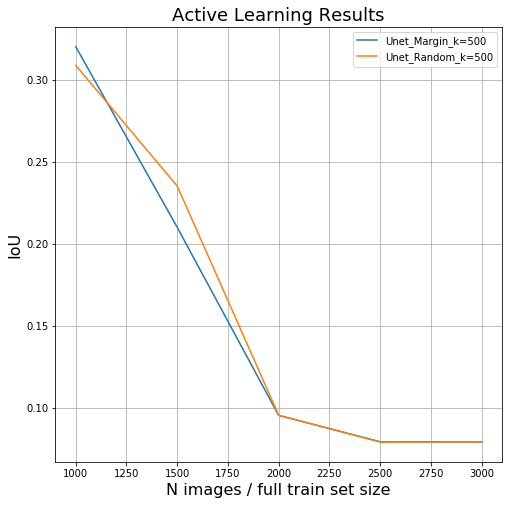

In [7]:
results = pickle_load('./results/'+RESULTS_FNAME)

plt.figure(figsize=(8,8))

# choose model
for model_str in MODELS:    
    # choose samples selection function
    for samples_selection_str in SAMPLES_SELECTIONS:        
        # choose number of samples to select for labelling from inference results
        for k in NUM_UNCERTAIN_IMAGES:

            ious = results[model_str][samples_selection_str][str(k)]['IoUs']
            n_train = results[model_str][samples_selection_str][str(k)]['N_train_samples']

            plt.plot(np.array(n_train[1:]), ious[1:], label=model_str+'_'+samples_selection_str+'_k='+str(k))
        
plt.grid()
plt.title('Active Learning Results', fontsize=18)
plt.xlabel('N images / full train set size', fontsize=16)
plt.ylabel('IoU', fontsize=16)
plt.legend();